In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy
import pandas as pd
from scipy.constants import c, h, e
from scipy.signal import find_peaks
from scipy.integrate import simpson

In [2]:

dir_bilayers = r'Measurements2025_01_14/'
dir_monolayer = r'Measurements2025_01_15/'
dir_monolayer2 = r'Measurements2025_01_17/'

In [3]:
power_coef = 11*0.5*1e6         #Estimation of the power in the sample

background_bilayers = np.loadtxt(dir_bilayers+'Background_2_s_101328.dat')
background_monolayer = np.loadtxt(dir_monolayer+'Background_2_s_101117.dat')
background_monolayer2 = np.loadtxt(dir_monolayer2+'Background_1_s_105736.dat')

In [4]:
x_axis_nm = np.loadtxt('calibration_x_axis.txt')
x_axis_eV = (h*c) / (x_axis_nm*1e-9) / e

In [45]:
class PD_spectra:
    def __init__(self, name, folder, background, acquisition_time, x_axis, power_coef=1.0, reversibility=False):
        """
        Initializes the PD_spectrum class.

        Parameters:
        name (str): Name of the spectrum.
        folder (str): Path to the folder containing spectral data.
        background (numpy.ndarray): 1D array representing background signal.
        acquisition_time (float): Acquisition time for the measurements (ms).
        x_axis (numpy.ndarray): 1D array representing the x-axis values (e.g., wavelength or energy).
        power_coef (float): Coefficient to convert measured powers to estimated power at the sample.
        reversibility (bool): Whether the spectrum is a reversibility test or not.
        """
        self.name = name
        self.folder = folder
        self.spectra = np.loadtxt(f"{folder}/spectra.txt").T
        self.powers = np.loadtxt(f"{folder}/measured_powers.txt") * power_coef
        self.background = background
        self.acquisition_time = acquisition_time
        self.x_axis = x_axis
        self.power_coef = power_coef
        self.reversibility = reversibility
        self.maximals, self.peak_positions, self.integrated_intensity, self.widths = self.compute_spectral_properties()

    @staticmethod
    def delta_points(self,x, spectrum, bkg):
        """
        Computes the width of a single spectrum.
        """
        spectrum = spectrum - bkg 
        amax = np.argmax(spectrum)
        max_value = np.mean(spectrum[amax-5:amax+6])
        normalized_spectrum = spectrum / max_value
        temp_spec = np.abs(normalized_spectrum - 0.5)
        amin1 = np.argmin(temp_spec[0:amax])
        amin2 = np.argmin(temp_spec[amax:])
        delta_eV = x[amin2 + amax] - x[amin1]
        return np.abs(delta_eV)
     
    def compute_spectral_properties(self):
        """
        Computes maximal intensities, peak positions, and integrated intensities.
        """
        maximals = np.array([max((spectrum - self.background) / (self.acquisition_time * 1e-3)) for spectrum in self.spectra])
        peak_positions = np.array([self.x_axis[scipy.signal.find_peaks(spectrum, prominence=200, width=30)[0][0]] for spectrum in self.spectra])
        integrated_intensity = np.array([scipy.integrate.simpson((spectrum - self.background) / (self.acquisition_time * 1e-3)) for spectrum in self.spectra])
        widths = np.array([self.delta_points(self, self.x_axis, spectrum, self.background) for spectrum in self.spectra])

        return maximals, peak_positions, integrated_intensity, widths

    
    def plot_spectral_property(self, property_name, mode ='all', title=None, filename=None, x_label=r'Power ($\mu$W)', y_label=None, font_size=18, fig_size=(10, 10)):
        """
        Plots the selected spectral property and returns the figure.

        Parameters:
        property_name (str): Name of the spectral property to plot. Options are:
            - "maximals": Maximal intensities.
            - "peak_positions": Peak positions.
            - "integrated_intensity": Integrated intensities.
            - "widths": Peak widths.
        mode (str): Plot mode. Options are:
            - "all": Plots all the spectra properties.
            - "ascending": Plots the first half of the spectra properties (only for reversibility test).
            - "descending": Plots the second half of the spectra properties (only for reversibility test).
        title (str): Title of the plot.
        filename (str): Name of the file to save the plot.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        font_size (int): Font size for the plot.
        fig_size (tuple): Figure size (width, height) in inches.
        
        Returns:
        matplotlib.figure.Figure: The generated figure object.
        """
        plt.rcParams.update({'font.size': font_size})
        fig, ax = plt.subplots(figsize=fig_size)
        
        if property_name == "maximals":
            y_data = self.maximals
        elif property_name == "peak_positions":
            y_data = self.peak_positions
        elif property_name == "integrated_intensity":
            y_data = self.integrated_intensity
        elif property_name == "widths":
            y_data = self.widths
        else:
            raise ValueError("Invalid property name. Choose from 'maximals', 'peak_positions', 'integrated_intensity', or 'widths'.")
        
        if self.reversibility:
            half = len(self.powers) // 2
            if mode == "ascending":
                y_data = y_data[:half]
                ax.plot(self.powers[:half], y_data, 'ro', label = 'Increasing power')
            elif mode == "descending":
                y_data = y_data[half:]
                ax.plot(self.powers[half:], y_data, 'bo', label = 'Decreasing power')
            elif mode == "all":
                ax.plot(self.powers[:half], y_data[:half], 'ro', label = 'Increasing power')
                ax.plot(self.powers[half:], y_data[half:], 'bo', label = 'Decreasing power')
            else:  
                raise ValueError("Invalid mode. Choose from 'ascending', 'descending', or 'all'.")

        else:
            ax.plot(self.powers, y_data, 'ro')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)
        ax.legend()
        
        if filename is not None:
            fig.savefig(filename)

        return fig

    def plot_all_spectral_properties(self, mode='all', title=None, filename=None, font_size=18, fig_size=(8, 12), y_labels=['Integrated Intensity (counts/s)', 'Peak Position (eV)', 'Width (eV)']):
        """
        Plots peak positions, integrated intensity, and widths in a single figure with three subplots, supporting different modes.
        """
        fig, axes = plt.subplots(3, 1, figsize=fig_size, sharex=False)
        plt.rcParams.update({'font.size': font_size})
        
        for ax, (data, y_label, color, marker) in zip(axes, [(self.integrated_intensity, y_labels[0], 'r', 'o'),
                                                            (self.peak_positions, y_labels[1], 'b', 's'),
                                                            (self.widths, y_labels[2], 'g', 'v')]):
            if self.reversibility:
                half = len(self.powers) // 2
                if mode == "ascending":
                    ax.plot(self.powers[:half], data[:half], f'{color}{marker}', label='Increasing power')
                elif mode == "descending":
                    ax.plot(self.powers[half:], data[half:], f'{color}{marker}', label='Decreasing power')
                else:
                    ax.plot(self.powers[:half], data[:half], f'r{marker}', label='Increasing power')
                    ax.plot(self.powers[half:], data[half:], f'b{marker}', label='Decreasing power')
            else:
                ax.plot(self.powers, data, f'{color}o')
            ax.set_ylabel(y_label)
            ax.legend()
            ax.set_xlabel(r'Power ($\mu$W)')
            
        
        if title:
            fig.suptitle(title)
        plt.tight_layout()
        if filename:
            fig.savefig(filename)
        
        
        return fig


    def plot_PD_spectra(self, mode="all", title=None,
                    filename=None, x_label='Energy (eV)', font_size=18, 
                    legend_ncol=1, steps=1, fig_size=(10, 10),
                    separate_plots=False, ind_fig_size=(7, 7),
                    ind_filenames=[None, None], line_width=1):
        """
        Plots the spectra based on the selected mode and returns the figure.

        Parameters:
        mode (str): Plot mode. Options are:
            - "all": Plots all spectra.
            - "ascending": Plots the first half of spectra (only for reversibility test).
            - "descending": Plots the second half of spectra (only for reversibility test).
        title (str): Title of the plot.
        filename (str): Name of the file to save the plot.
        x_label (str): Label for the x-axis.
        font_size (int): Font size for the plot.
        legend_ncol (int): Number of columns in the legend.
        steps (int): Number of steps to skip between plotted spectra.
        fig_size (tuple): Figure size (width, height) in inches.
        separate_plots (bool): If True, returns separate figures for each subplot.

        Returns:
        dict: Contains:
            - "combined": The main figure with both subplots.
            - "individual_0": First subplot figure (optional).
            - "individual_1": Second subplot figure (optional).
        """
        if self.reversibility:
            half = len(self.powers) // 2
            if mode == "ascending":
                spectra_to_plot = self.spectra[:half:steps]
                powers_to_plot = self.powers[:half:steps]
            elif mode == "descending":
                spectra_to_plot = self.spectra[half::steps]
                powers_to_plot = self.powers[half::steps]
            elif mode == "all":
                spectra_to_plot = self.spectra[::steps]
                powers_to_plot = self.powers[::steps]
            else:
                raise ValueError("Invalid mode. Choose from 'ascending', 'descending', or 'all'.")
        else:
            if mode != "all":
                raise ValueError("Invalid mode for non-reversibility test. Use 'all'.")
            spectra_to_plot = self.spectra[::steps]
            powers_to_plot = self.powers[::steps]

        plt.rcParams.update({'font.size': font_size})
        norm = plt.Normalize(min(self.powers) - 0.1 * max(self.powers), max(self.powers))
        
        # Create main figure with subplots
        fig, axs = plt.subplots(2, 1, figsize=fig_size)
        
        for ii in range(len(spectra_to_plot)):
            if mode == "all" and self.reversibility:
                cmap = cm.Reds if ii < half // steps else cm.Blues
            elif mode == "descending":
                cmap = cm.Blues
            else:
                cmap = cm.Reds

            color = cmap(norm(powers_to_plot[ii]))
            
            axs[0].plot(self.x_axis, (spectra_to_plot[ii] - self.background) / (self.acquisition_time * 1e-3), 
                        color=color, label=f"{powers_to_plot[ii]:.2f}", linewidth=line_width)
            axs[1].plot(self.x_axis, (spectra_to_plot[ii] - self.background) / max(spectra_to_plot[ii] - self.background), 
                        color=color, label=f"{powers_to_plot[ii]:.2f}", linewidth=line_width)

        axs[0].set_ylabel('Intensity (counts/s)')
        axs[1].set_ylabel('Normalized Intensity')
        axs[0].set_xlabel(x_label)
        axs[1].set_xlabel(x_label)
        axs[0].legend(title=r'Power ($\mu$W)', ncol=legend_ncol)
        axs[1].legend(title=r'Power ($\mu$W)', ncol=legend_ncol)
        axs[0].set_title(title, fontsize=font_size+3)

        if filename is not None:
            fig.savefig(filename)

        results = {"combined": fig}

        if separate_plots:
            # Create and store separate figures
            for i in range(2):
                fig_sep, ax_sep = plt.subplots(figsize=ind_fig_size)  # Adjust individual figure size
                for line in axs[i].lines:
                    ax_sep.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color(), linewidth=line_width)
                ax_sep.set_ylabel(axs[i].get_ylabel())
                ax_sep.set_xlabel(x_label)
                ax_sep.legend(title=r'Power ($\mu$W)', ncol=legend_ncol)
                ax_sep.set_title(axs[i].get_title() if i == 0 else "Normalized Intensity")
                results[f"individual_{i}"] = fig_sep
                if ind_filenames[i] is not None:
                    fig_sep.savefig(ind_filenames[i])

        return results


In [46]:
supported_bilayer = PD_spectra("Supported bilayer", dir_bilayers+'172200', background_bilayers, 2000, x_axis_eV, power_coef, reversibility=True)
supported_bilayer_2 = PD_spectra("Supported bilayer 2", dir_bilayers+'153154', background_bilayers, 2000, x_axis_eV, power_coef, reversibility=True)#This is not actually supported
suspended_bilayer_1 = PD_spectra("Suspended bilayer 1", dir_bilayers+'154359', background_bilayers, 2000, x_axis_eV, power_coef, reversibility=True)
suspended_bilayer_2 = PD_spectra("Suspended bilayer 2", dir_bilayers+'155338', background_bilayers, 2000, x_axis_eV, power_coef, reversibility=True)
supported_monolayer = PD_spectra("Supported monolayer", dir_monolayer+'143608', background_monolayer, 2000, x_axis_eV, power_coef, reversibility=True)
suspended_monolayer = PD_spectra("Suspended monolayer", dir_monolayer2+'152946', background_monolayer2, 1000, x_axis_eV, power_coef, reversibility=True)


In [42]:
%matplotlib qt

fileName = 'Figures/Suspended_monolayer_PL.pdf'
PD_spectra.plot_PD_spectra(suspended_monolayer, mode="ascending", legend_ncol=1, steps=1, separate_plots=False, line_width=2.5, fig_size=(10, 14), title=f'Suspended monolayer $WSe_2$', filename=fileName)

{'combined': <Figure size 1000x1400 with 2 Axes>}

In [57]:
%matplotlib qt
#Comparing bilayer and monolayer PL
plt.figure(figsize=(10,7))
plt.plot(supported_bilayer.x_axis, (supported_bilayer.spectra[3] - supported_bilayer.background) / (supported_bilayer.acquisition_time*1e-3), label = 'Bilayer')
plt.plot(supported_bilayer.x_axis, (supported_monolayer.spectra[8] - supported_monolayer.background) / (supported_bilayer.acquisition_time*1e-3), label = 'Monolayer')
plt.ylabel('Intensity (counts/s)')
plt.xlabel('Energy (eV)')
#plt.xlim(1.25, 1.99)
plt.legend()
plt.savefig('Figures/Supported_bilayer_vs_monolayer_PL.pdf')

plt.show()

In [88]:
%matplotlib qt
#Comparing suspended and supported bilayer PL at low excitation power

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(9,5))
plt.plot(supported_bilayer.x_axis, 20*(supported_bilayer.spectra[0] - supported_bilayer.background) / (supported_bilayer.acquisition_time*1e-3), label = 'Supported x20')
plt.plot(suspended_bilayer_1.x_axis, (suspended_bilayer_1.spectra[0] - suspended_bilayer_1.background) / (suspended_bilayer_1.acquisition_time*1e-3), label = 'Suspended')
plt.ylabel('Intensity (counts/s)')
plt.xlabel('Energy (eV)')
#plt.xlim(1.25, 1.99)
plt.legend()
plt.tight_layout()
plt.savefig('Figures/Supported_vs_suspended_bilayer_PL.pdf')

plt.show()

In [120]:
#Comparing bilayer PL at high excitation power

plt.figure(figsize=(9,6))
plt.plot(suspended_bilayer_1.x_axis, (suspended_bilayer_1.spectra[7] - suspended_bilayer_1.background) / (suspended_bilayer_1.acquisition_time*1e-3), label = 'Suspended (1st cycle)')
plt.plot(suspended_bilayer_2.x_axis, (suspended_bilayer_2.spectra[7]-suspended_bilayer_2.background)/(suspended_bilayer_2.acquisition_time*1e-3), label = 'Suspended (2nd cycle)')
plt.plot(supported_bilayer.x_axis, (supported_bilayer.spectra[19]-supported_bilayer.background)/(supported_bilayer.acquisition_time*1e-3), label = 'Supported')

plt.xlabel('Energy (eV)')
plt.ylabel('Intensity (counts/s)')
plt.legend()
plt.tight_layout()
plt.savefig('Figures/High_power_bilayer_comparison.pdf')
plt.show()

In [34]:
#Comparing bilayer integrated intensity

half=len(suspended_bilayer_1.powers)//2
plt.figure(figsize=(8,6))
plt.plot(suspended_bilayer_1.powers[:half], suspended_bilayer_1.integrated_intensity[:half], 'r-o', label='Increasing power (first cycle)')
plt.plot(suspended_bilayer_1.powers[half:], suspended_bilayer_1.integrated_intensity[half:], 'b-o', label='Decreasing power (first cycle)')
plt.plot(suspended_bilayer_2.powers[:half], suspended_bilayer_2.integrated_intensity[:half], 'g-o', label='Increasing power (second cycle)')

plt.xlabel(r'Power ($\mu$W)')
plt.ylabel('Integrated Intensity (counts/s)')

plt.title(f'Suspended bilayer $WSe_2$')
plt.legend()
plt.tight_layout()
plt.savefig('Figures/Integrated_intensity_comparison_bilayer.pdf')
plt.show()

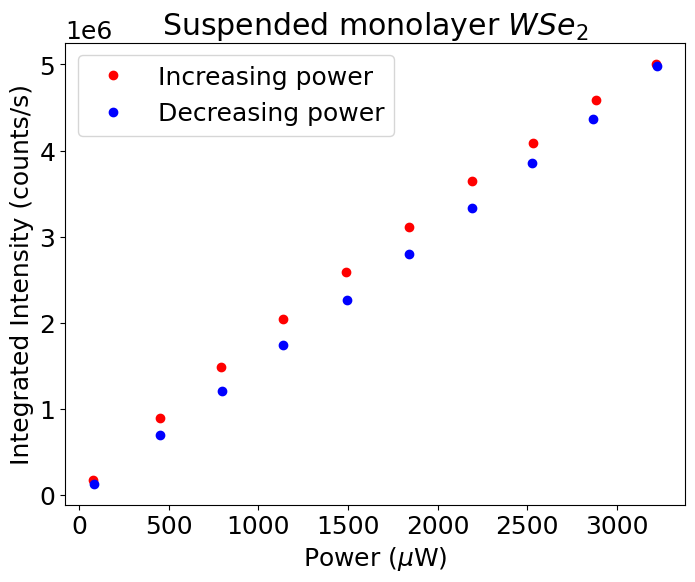

In [43]:
#Plot one spectral property
PD_spectra.plot_spectral_property(suspended_monolayer, "integrated_intensity", mode="all", x_label=r'Power ($\mu$W)', y_label='Integrated Intensity (counts/s)',filename='Figures/Suspended_monolayer_II.pdf', fig_size=(8,6), title=f'Suspended monolayer $WSe_2$')

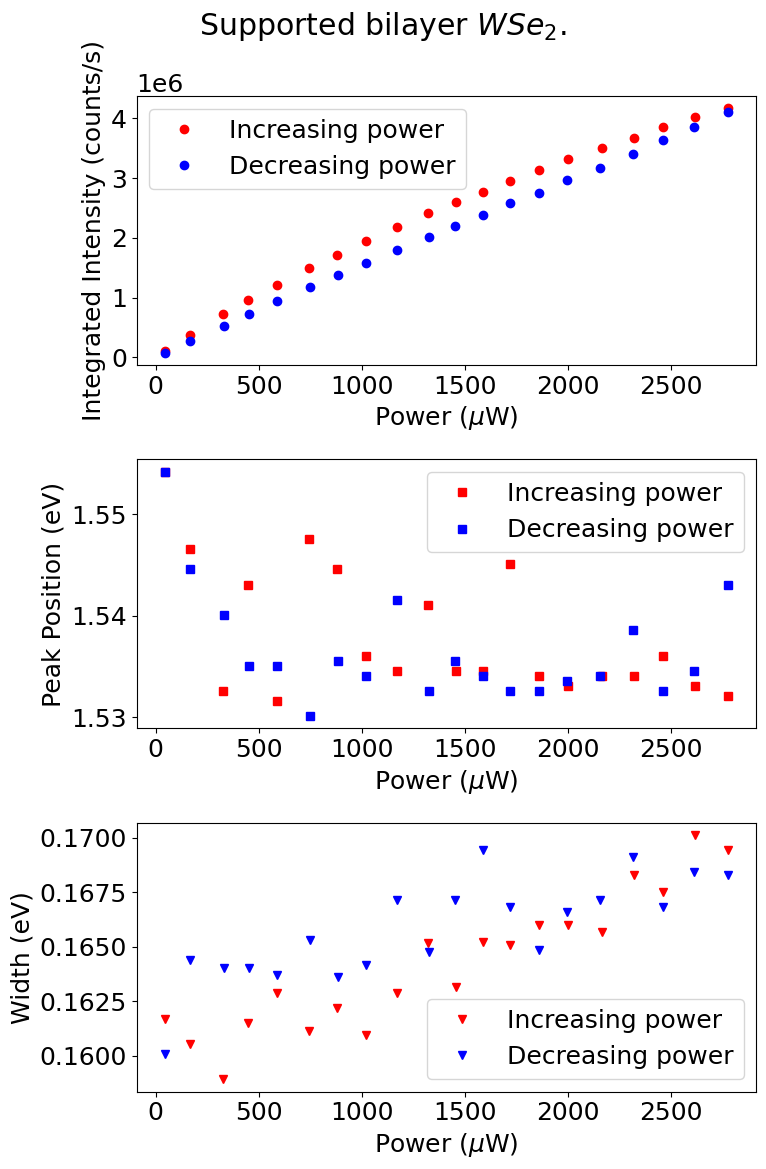

In [49]:
%matplotlib qt
#Plot all the spectral properties 
PD_spectra.plot_all_spectral_properties(supported_bilayer, mode='all', fig_size=(8,12), filename='Figures/Combined_plot0.pdf', title=f'Supported bilayer $WSe_2$.')

In [44]:
#Widths vs peak position correlation
%matplotlib qt
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()

powers = suspended_bilayer_2.powers
widths = suspended_bilayer_2.widths
peak_positions = suspended_bilayer_2.peak_positions


reversibility = True
if reversibility == True:
    plt.plot(peak_positions[0:len(powers)//2], widths[0:len(powers)//2], 'ro', label='Increasing power')            
    plt.plot(peak_positions[len(powers)//2:], widths[len(powers)//2:], 'bo', label='Decreasing power')
    for i in range(len(powers)//2 - 1):
        ax.annotate("", 
                xy=(peak_positions[i+1], widths[i+1]), 
                xytext=(peak_positions[i], widths[i]),
                arrowprops=dict(arrowstyle="->,head_length=0.5,head_width=0.5", 
                color='red', linestyle='dashed', linewidth=1.5, connectionstyle="arc3,rad=0"))

    for i in range(len(powers)//2, len(powers) - 1):
        ax.annotate("", 
                xy=(peak_positions[i+1], widths[i+1]), 
                xytext=(peak_positions[i], widths[i]),
                arrowprops=dict(arrowstyle="->,head_length=0.5,head_width=0.5", 
                color='blue', linestyle='dashed', linewidth=1.5, connectionstyle="arc3,rad=0"))


plt.xlabel(r"Peak positions (eV)")
plt.ylabel("Width (eV)")
plt.title(f'Suspended bilayer $WSe_2$. \nSecond cycle')
plt.legend()
plt.tight_layout()
#save_interactive_fig(fig, r'Integrated_intensity_bilayer_2_low.pkl', r'Integrated_intensity_bilayer_2_low.pyx')

plt.savefig('Figures/Positions_vs_widths_2.pdf')
plt.show()